In [0]:
# !pip install -q keras-bert
!pip install livelossplot
import pandas as pd
import numpy as np
from tqdm import tqdm
import re
import matplotlib.pyplot as plt
import keras
# import keras_bert
import os
# import codecs
from gensim.models import Word2Vec
import tensorflow as tf
from livelossplot import PlotLossesKeras

Using TensorFlow backend.


In [0]:
!git clone https://github.com/snipsco/nlu-benchmark.git

Cloning into 'nlu-benchmark'...
remote: Enumerating objects: 11, done.
remote: Counting objects: 100% (11/11), done.
remote: Compressing objects: 100% (9/9), done.
remote: Total 389 (delta 2), reused 11 (delta 2), pack-reused 378
Receiving objects: 100% (389/389), 1.24 MiB | 2.68 MiB/s, done.
Resolving deltas: 100% (242/242), done.


In [0]:
# cd nlu-benchmark/

/content/nlu-benchmark


In [0]:
# ls -ltr

total 24
drwxr-xr-x 2 root root 4096 Sep  6 15:32 2016-12-built-in-intents/
drwxr-xr-x 9 root root 4096 Sep  6 15:32 2017-06-custom-intent-engines/
drwxr-xr-x 3 root root 4096 Sep  6 15:32 2018-01-Braun-et-al-extension/
-rwxr-xr-x 1 root root 1921 Sep  6 15:32 README.md*
-rw-r--r-- 1 root root 6555 Sep  6 15:32 LICENSE


In [0]:
# cd 2017-06-custom-intent-engines/

In [0]:
# ls -ltr

In [0]:
# cd ..

In [0]:
# ls -ltr

In [0]:
# !wget http://nlp.stanford.edu/data/glove.840B.300d.zip

--2019-09-03 11:05:13--  http://nlp.stanford.edu/data/glove.840B.300d.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.840B.300d.zip [following]
--2019-09-03 11:05:13--  https://nlp.stanford.edu/data/glove.840B.300d.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.840B.300d.zip [following]
--2019-09-03 11:05:13--  http://downloads.cs.stanford.edu/nlp/data/glove.840B.300d.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2176768927 (2.0G) [application/zip

In [0]:
# !unzip glove.840B.300d.zip

Archive:  glove.840B.300d.zip.1
  inflating: glove.840B.300d.txt     


In [0]:
# !wget -q https://storage.googleapis.com/bert_models/2018_10_18/uncased_L-12_H-768_A-12.zip
# !unzip -o uncased_L-12_H-768_A-12.zip

Archive:  uncased_L-12_H-768_A-12.zip
   creating: uncased_L-12_H-768_A-12/
  inflating: uncased_L-12_H-768_A-12/bert_model.ckpt.meta  
  inflating: uncased_L-12_H-768_A-12/bert_model.ckpt.data-00000-of-00001  
  inflating: uncased_L-12_H-768_A-12/vocab.txt  
  inflating: uncased_L-12_H-768_A-12/bert_model.ckpt.index  
  inflating: uncased_L-12_H-768_A-12/bert_config.json  


# Data

In [0]:
class json_data:
    
    def __init__(self,json_file):
        self.df = pd.read_json(json_file)
        self.data = self.df.iloc[:,0]
    
    def extract_text(self):
        text = []
#         text.append([re.sub(' +',' ',re.sub('[^a-zA-Z\d\s]','',''.join([self.data[i]['data'][j]['text'] for j in range(len(self.data[i]['data']))]).lower())) for i in tqdm(range(len(self.data)))])
        text.append([''.join([self.data[i]['data'][j]['text'] for j in range(len(self.data[i]['data']))]) for i in tqdm(range(len(self.data)))])
        return text

    def extract_entity(self):
        entity = []
        for i in tqdm(range(len(self.data))):
            row = self.data[i]['data']
            dumm = []
            for j in range(len(row)):
                try:
                    dumm+=[row[j]['entity']]*len(row[j]['text'].strip().split(' '))
                except:
                    dumm+=['O']*len(row[j]['text'].strip().split(' '))
            entity.append(dumm)
        return entity
        
    def get_data(self):
        text = self.extract_text()
        entity = self.extract_entity()
        return text,entity

In [0]:
atp = json_data('./nlu-benchmark/2017-06-custom-intent-engines/AddToPlaylist/train_AddToPlaylist.json')
atp_text,atp_entity = atp.get_data()

100%|██████████| 300/300 [00:00<00:00, 38608.55it/s]


In [0]:
br = json_data('./nlu-benchmark/2017-06-custom-intent-engines/BookRestaurant/train_BookRestaurant.json')
br_text,br_entity = br.get_data()

100%|██████████| 300/300 [00:00<00:00, 44377.91it/s]


In [0]:
gw = json_data('./nlu-benchmark/2017-06-custom-intent-engines/GetWeather/train_GetWeather.json')
gw_text,gw_entity = gw.get_data()

100%|██████████| 300/300 [00:00<00:00, 50325.61it/s]


In [0]:
pm = json_data('./nlu-benchmark/2017-06-custom-intent-engines/PlayMusic/train_PlayMusic.json')
pm_text,pm_entity = pm.get_data()

100%|██████████| 300/300 [00:00<00:00, 54022.46it/s]


In [0]:
rb = json_data('./nlu-benchmark/2017-06-custom-intent-engines/RateBook/train_RateBook.json')
rb_text,rb_entity = rb.get_data()

100%|██████████| 300/300 [00:00<00:00, 44613.93it/s]


In [0]:
scw = json_data('./nlu-benchmark/2017-06-custom-intent-engines/SearchCreativeWork/train_SearchCreativeWork.json')
scw_text,scw_entity = scw.get_data()

100%|██████████| 300/300 [00:00<00:00, 53170.98it/s]


In [0]:
sse = json_data('./nlu-benchmark/2017-06-custom-intent-engines/SearchScreeningEvent/train_SearchScreeningEvent.json')
sse_text,sse_entity = sse.get_data()

100%|██████████| 300/300 [00:00<00:00, 51449.12it/s]


In [0]:
text = np.hstack([atp_text,br_text,gw_text,pm_text,rb_text,scw_text,sse_text])[0]

In [0]:
entity = np.concatenate([atp_entity,br_entity,gw_entity,pm_entity,rb_entity,scw_entity,sse_entity])

In [0]:
intent = [i//300 for i in range(len(text))]

# Preprocessing

In [0]:
# def shuffle(text,entity):
#     ind = np.arange(len(text))
#     np.random.shuffle(ind)
#     text_shfl = [text[ind[i]] for i in range(len(text))]
#     entity_shfl = [entity[ind[i]] for i in range(len(entity))]
#     return text_shfl,entity_shfl

In [0]:
def max_len(arr):
    maxx = len(arr[0])
    for i in range(len(arr)):
        if(maxx<len(arr[i])):
            maxx = len(arr[i])
    return maxx

In [0]:
# text,entity = shuffle(text,entity)

In [0]:
ind = np.arange(len(text))
np.random.shuffle(ind)
train_ind = ind[:-200]
test_ind = ind[-200:]

## Distribution

In [0]:
dist = [0 for i in range(4)]
for i in range(1,len(entity)):
    if(len(entity[i])<5):
        dist[0]+=1
    elif(len(entity[i])<10):
        dist[1]+=1
    elif(len(entity[i])<15):
        dist[2]+=1
    elif(len(entity[i])>15):
        dist[3]+=1

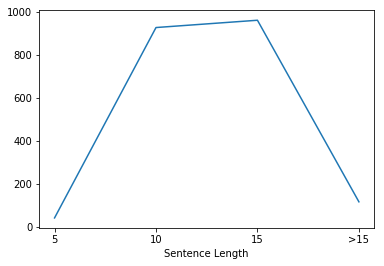

In [0]:
plt.plot(['5','10','15','>15'],dist)
plt.xlabel('Sentence Length')
plt.show()

In [0]:
max_len(entity)

27

## Bert_embeddings

In [0]:
# pretrained_path = './uncased_L-12_H-768_A-12'
# config_path = os.path.join(pretrained_path,'bert_config.json')
# ckpt_path = os.path.join(pretrained_path,'bert_model.ckpt')
# vocab_path = os.path.join(pretrained_path,'vocab.txt')

In [0]:
# token_dict = {}
# with codecs.open(vocab_path, 'r', 'utf8') as reader:
#     for line in reader:
#         token = line.strip()
#         token_dict[token] = len(token_dict)
# tokenizer = keras_bert.Tokenizer(token_dict)

In [0]:
# def embed(text_arr,max_len):
#     ind_array = []
#     seg_array = []
#     for i in range(len(text_arr)):
#         ind,seg = tokenizer.encode(first=text_arr[i],max_len=max_len)
#         ind_array.append(ind)
#         seg_array.append(seg)
#     ind_array = np.array(ind_array)
#     seg_array = np.array(seg_array)
#     return ind_array,seg_array

In [0]:
# bert = keras_bert.load_trained_model_from_checkpoint(config_path,ckpt_path,training=False,trainable=False,seq_len=32)

In [0]:
# inpt = bert.inputs[:2]
# out = bert.get_layer('Embedding-Norm').output
# print(out.shape)
# embedding = keras.models.Model(inpt,out)

(?, 32, 768)


## GLOVE

In [0]:
# text_dic = {}
# entity_dic = {}
# ctr = 0
# ectr = 0
# for i in tqdm(range(len(text))):
#     text_split = text[i].lower().strip().split(' ')
#     entity_split = entity[i]
#     for j in range(len(text_split)):
#         if(text_split[j] not in text_dic):
#             text_dic[text_split[j]] = ctr
#             ctr+=1
#         try:
#             if(entity_split[j] not in entity_dic):
#                 entity_dic[entity_split[j]] = ectr
#                 ectr+=1
#         except:
#             print(i)

100%|██████████| 2100/2100 [00:00<00:00, 160367.75it/s]


In [0]:
ctr

3456

In [0]:
# glove_dic = {}
# ctr2 = 0
# with open('glove.840B.300d.txt') as file:
#     line = file.readline().split(' ')
#     while(line and ctr2<3143):#ctr):
#         if(''.join(line[:-300]) != '' and ''.join(line[:-300]) in text_dic):
#             try:
#                 glove_dic[''.join(line[:-300])] = list(map(float,line[-300:]))
#                 ctr2 += 1
#                 print(ctr2)
#             except:
#                 pass
#         line = file.readline().split(' ')

In [0]:
# for key,val in text_dic.items():
#     if(key not in glove_dic):
#         print(key)

In [0]:
# glove_dic = {}
# with open('glove.42B.300d.txt') as file:
#     for i in tqdm(range(ctr)):
#         line = file.readline().split(' ')
#         glove_dic[''.join(line[:-300])] = list(map(float,line[-300:]))

 58%|█████▊    | 1114962/1917495 [01:28<01:00, 13266.41it/s]

## Word2Vec

In [0]:
text_token = [keras.preprocessing.text.text_to_word_sequence(text[i], filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n', lower=True, split=' ') for i in range(len(text))]

In [0]:
text_token.append(['<PAD>'])

In [0]:
emb_size = 50
embed = Word2Vec(text_token,min_count=1,size=emb_size)

W0904 20:33:49.347602 140504677635968 base_any2vec.py:723] consider setting layer size to a multiple of 4 for greater performance
W0904 20:33:49.485596 140504677635968 base_any2vec.py:1386] under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay


In [0]:
entity_dic = {}
ctr = 0
for i in tqdm(range(len(entity))):
    entity_split = entity[i]
    for j in range(len(entity_split)):
        if(entity_split[j] not in entity_dic):
            entity_dic[entity_split[j]] = ctr
            ctr+=1

100%|██████████| 2100/2100 [00:00<00:00, 384613.70it/s]


## Data generator

In [0]:
def test_generator(text_token,entity,intent,batch_size=32):
    while True:
        ind = np.random.choice(test_ind,size=batch_size)
        select_entity = [entity[ind[i]] for i in range(batch_size)]
        pad = max_len(select_entity)
        batch_text = []
        batch_entity = []
        batch_intent = keras.utils.to_categorical([intent[ind[i]] for i in range(batch_size)],num_classes=7)
        for i in range(batch_size):
            ent = entity[ind[i]]
            txt = text_token[ind[i]]
            batch_entity.append([entity_dic[ent[j]] if j<len(ent)
                                 else entity_dic['O'] 
                                 for j in range(pad)])
            batch_text.append([embed[txt[j]] if j<len(txt)
                               else embed['<PAD>'] 
                               for j in range(pad)])
        batch_text = np.array(batch_text)
        batch_entity = keras.utils.to_categorical(batch_entity,num_classes=len(entity_dic))
        
        yield(batch_text,[batch_entity,batch_intent])

In [0]:
def train_generator(text_token,entity,intent,batch_size=32):
    while True:
        ind = np.random.choice(train_ind,size=batch_size)
        select_entity = [entity[ind[i]] for i in range(batch_size)]
        pad = max_len(select_entity)
        batch_text = []
        batch_entity = []
        batch_intent = keras.utils.to_categorical([intent[ind[i]] for i in range(batch_size)],num_classes=7)
        for i in range(batch_size):
            ent = entity[ind[i]]
            txt = text_token[ind[i]]
            batch_entity.append([entity_dic[ent[j]] if j<len(ent)
                                 else entity_dic['O'] 
                                 for j in range(pad)])
            batch_text.append([embed[txt[j]] if j<len(txt)
                               else embed['<PAD>'] 
                               for j in range(pad)])
        batch_text = np.array(batch_text)
        batch_entity = keras.utils.to_categorical(batch_entity,num_classes=len(entity_dic))
        
        yield(batch_text,[batch_entity,batch_intent])

# Model

In [0]:
gru_units = 64

In [0]:
inpt = keras.layers.Input((None,emb_size))
gru_out,gru_h = keras.layers.CuDNNGRU(gru_units,return_sequences=True,return_state=True)(inpt)
x = keras.layers.Dense(32,activation='relu')(gru_h)
intent_out = keras.layers.Dense(7,activation='softmax',name='intent')(x)
# intnt = keras.layers.Lambda(lambda x: tf.tile(x,gru_out.shape[1]))(intent_out)
# y = keras.layers.Concatenate([intnt,gru_out])
# y = keras.layers.CuDNNGRU(gru_units,return_sequences=True)(y)
y = keras.layers.Dense(32,activation='relu')(gru_out)
entity_out = keras.layers.Dense(len(entity_dic),activation='softmax',name='entity')(y)
model = keras.models.Model(inpt,[entity_out,intent_out])

In [0]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, None, 50)     0                                            
__________________________________________________________________________________________________
cu_dnngru_2 (CuDNNGRU)          [(None, None, 64), ( 22272       input_2[0][0]                    
__________________________________________________________________________________________________
dense_4 (Dense)                 (None, None, 32)     2080        cu_dnngru_2[0][0]                
__________________________________________________________________________________________________
dense_3 (Dense)                 (None, 32)           2080        cu_dnngru_2[0][1]                
____________________________________________________________________________________________

In [0]:
loss = {'entity':'categorical_crossentropy','intent':'categorical_crossentropy'}

In [0]:
model.compile(optimizer='adam',loss=loss,metrics=['acc'])

In [0]:
es = keras.callbacks.EarlyStopping(monitor='Log-loss (entity)',restore_best_weights=True,patience=200,verbose=1)

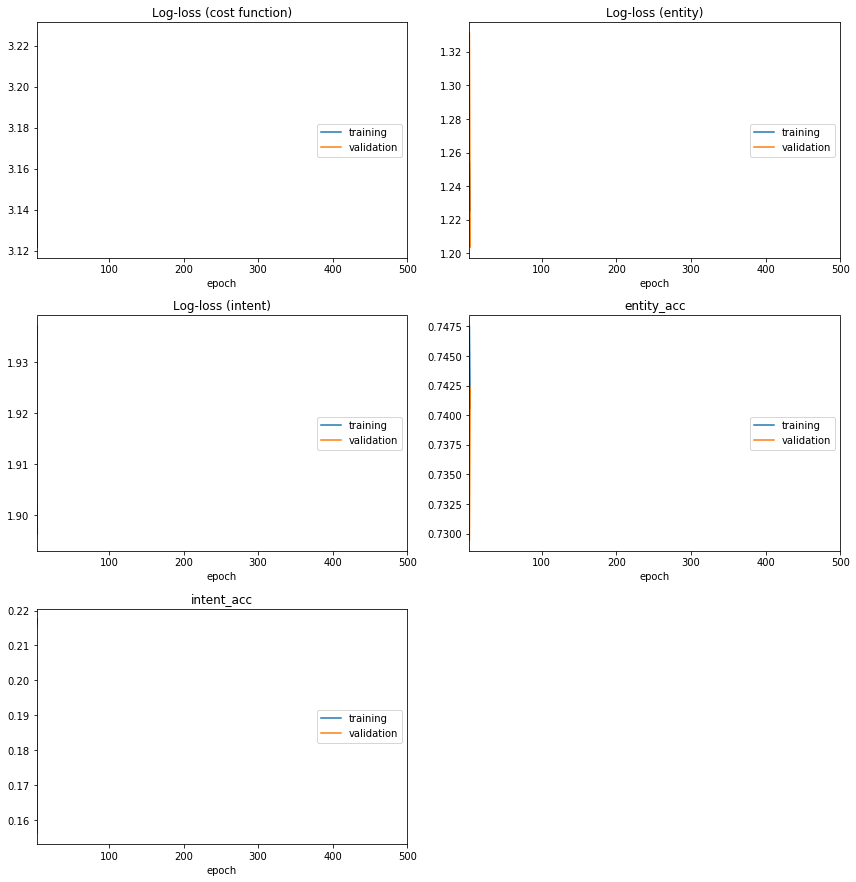

Log-loss (cost function):
training   (min:    3.122, max:    4.619, cur:    3.122)
validation (min:    3.141, max:    3.670, cur:    3.141)

Log-loss (entity):
training   (min:    1.226, max:    2.650, cur:    1.226)
validation (min:    1.204, max:    1.698, cur:    1.204)

Log-loss (intent):
training   (min:    1.896, max:    1.969, cur:    1.896)
validation (min:    1.895, max:    1.973, cur:    1.937)

entity_acc:
training   (min:    0.664, max:    0.750, cur:    0.741)
validation (min:    0.718, max:    0.742, cur:    0.742)

intent_acc:
training   (min:    0.157, max:    0.217, cur:    0.217)
validation (min:    0.156, max:    0.250, cur:    0.156)
Epoch 5/500
50/50 [==============================] - 0s 8ms/step - loss: 3.0847 - entity_loss: 1.2015 - intent_loss: 1.8833 - entity_acc: 0.7387 - intent_acc: 0.2137 - val_loss: 2.9959 - val_entity_loss: 1.1868 - val_intent_loss: 1.8091 - val_entity_acc: 0.7486 - val_intent_acc: 0.3625


In [0]:
history = model.fit_generator(train_generator(text_token,entity,intent),epochs=500,steps_per_epoch=50,validation_data=test_generator(text_token,entity,intent),validation_steps=5,callbacks=[PlotLossesKeras()])

In [0]:
model.save_weights('intent.h5')

# Inference

In [0]:
ind = test_ind
batch_size = len(ind)
select_entity = [entity[ind[i]] for i in range(batch_size)]
pad = max_len(select_entity)
batch_text = []
batch_entity = []
batch_intent = keras.utils.to_categorical([intent[ind[i]] for i in range(batch_size)],num_classes=7)
for i in range(batch_size):
    ent = entity[ind[i]]
    txt = text_token[ind[i]]
    batch_entity.append([entity_dic[ent[j]] if j<len(ent)
                         else entity_dic['O'] 
                         for j in range(pad)])
    batch_text.append([embed[txt[j]] if j<len(txt)
                       else embed['<PAD>'] 
                       for j in range(pad)])
batch_text = np.array(batch_text)
batch_entity = keras.utils.to_categorical(batch_entity,num_classes=len(entity_dic))

In [0]:
pred = model.predict(batch_text)

In [0]:
pred[0]

In [0]:
pred_intent = [np.argmax(pred[1][i]) for i in range(len(pred[1]))]
true_intent = [np.argmax(batch_intent[i]) for i in range(len(pred[1]))]

In [0]:
summ = 0
for i in range(len(pred_intent)):
    if(pred_intent[i]==np.argmax(batch_intent[i])):
        summ+=1
acc = summ/len(pred_intent)
print(acc)